# Quant analysis script for 2 plates

### Instructions:
This script will analyze quant data from the Tecan M1000 and output concentrations in ng/ul as well as a normalization file for the Tecan.

Run script cell-by-cell by pressing "shift + enter", providing input when required.

### Input required:
You will need a .csv file containing just the raw fluorescence measurements in 384w format.  You will need to have your standard curve plate in Quadrant




### Outputs:
The output will be a .csv file containing well/quant information as well as a .gwl file for normalization on the Tecan








___________



____

## STEP 1: Upload quant measurements and enter normalization values:
Use the form below to upload your .csv containing quant measurements from the M1000.  
You will also be prompted to enter the final volume and concentration for normalization.

In [1]:
## LIBRRAY IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, HBox, VBox, Layout, Label
import io
import re

quant_file = widgets.FileUpload(
    accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
    , description = "Input required! Upload .csv file containing your 384w quant measurements"
    #, style = {'description_width': 'initial'}
    , layout = Layout(width='50%', height='60px')
)

display(quant_file)

totalV_1 = widgets.FloatText(
     description='Final normalized volume for Plate 1 (ul): '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px'))
    

finalC_1 = widgets.FloatText(
    description='Final concentration for Plate 1 (ng/ul):     '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px')
    , label = Label(color = 'red')
)
    
totalV_2 = widgets.FloatText(
    description='Final normalized volume for Plate 2 (ul): '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px'))
    

finalC_2 = widgets.FloatText(
    description='Final concentration for Plate 2 (ng/ul): '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px'))
    
    


plate1 = widgets.Text(
    description='Plate 1 name (no spaces!): '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px')
    , placeholder='Plate 1')
plate2 = widgets.Text(
    description='Plate 2 name (no spaces!): '
    , disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='35%', height='30px')
    , color='#0022FF'
    , placeholder='Plate 2')

    
    

page1 = widgets.Box(children=[plate1, totalV_1, finalC_1])
page2 = widgets.Box(children=[plate2, totalV_2, finalC_2])

accord = widgets.Tab(children=[page1, page2], width=400)
accord.set_title(0, 'Plate 1')
accord.set_title(1, 'Plate 2')

display(accord)



FileUpload(value={}, accept='.csv', description='Input required! Upload .csv file containing your 384w quant m…

______


## STEP 2:  Visualize raw data and (optionally) remove wells from analysis
This cell will output a visualization of raw quant data from your file.  You can remove certain wells from analysis if you would like by entering them in the form below.

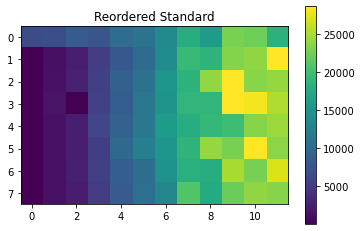

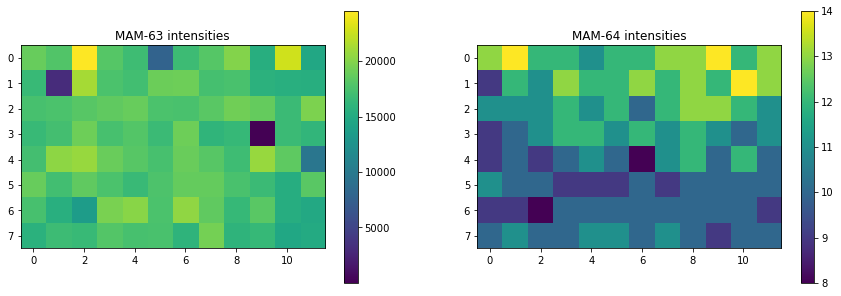

In [2]:
#quant_file = quant_file.value
# Set variables, file names, and metadata
quant_f = list(quant_file.value.values())[0]
quant_fn = quant_f['content']
quant_fn = io.StringIO(quant_fn.decode('utf-8'))
quant_fn = pd.read_csv(quant_fn, index_col = '<>')
quant_fn.head()
stdConc = [0,5,10,20,30,40,50,60,70,80,90,100] # ng/uL concentration of lambda DNA in standard DEFAULT

# Define row and column sets for each quadrant
alphabet = 'ABCDEFGHIJKLMNOP'
Q13_cols = [str(i) for i in list(range(1,25,2))]
Q24_cols = [str(i) for i in list(range(2,25,2))]
Q12_rows = [alphabet[i] for i in list(range(0,len(alphabet),2))]
Q34_rows = [alphabet[i] for i in list(range(1,len(alphabet),2))]

# Subset quadrants from the 384-well plate
Q1 = quant_fn.loc[Q12_rows,Q13_cols]

Q2 = quant_fn.loc[Q12_rows,Q24_cols]
Q2 = Q2.set_axis(["A","B","C","D","E","F","G","H"],axis=0)
Q2 = Q2.set_axis(range(1,13),axis = 1)

Q3 = quant_fn.loc[Q34_rows,Q13_cols]
Q3 = Q3.set_axis(["A","B","C","D","E","F","G","H"],axis=0)
Q3 = Q3.set_axis(range(1,13),axis = 1)

Q4 = quant_fn.loc[Q34_rows,Q24_cols]
Q4 = Q4.set_axis(["A","B","C","D","E","F","G","H"],axis=0)
Q4 = Q4.set_axis(range(1,13),axis = 1)




# Reorder the samples in Q1 (standard)
Q1_inv = Q1.iloc[[1,3,5,7], ::-1]
Q1_inv.rename(columns=dict(zip(Q1_inv.columns,Q1.columns)), inplace=True)
Q1_ord = pd.concat([Q1_inv, Q1.iloc[[0,2,4,6],:]]).sort_index()

plt.imshow(Q1_ord, cmap="viridis")
plt.title('Reordered Standard')
plt.colorbar()
plt.show()

Sample_Intensities = pd.DataFrame(0, index=["A","B","C","D","E","F","G","H"], columns=range(1,13))
Sample_Devs = pd.DataFrame(0, index=["A","B","C","D","E","F","G","H"], columns=range(1,13))


#for row_i in range(Q1.shape[0]):
#    for col_j in range(Q1.shape[1]):
#        Sample_Intensities.iloc[row_i, col_j] = np.mean([Q2.iloc[row_i, col_j], Q3.iloc[row_i, col_j], Q4.iloc[row_i, col_j]])
#        Sample_Devs.iloc[row_i, col_j] = np.std((Q2.iloc[row_i, col_j],Q3.iloc[row_i, col_j],Q4.iloc[row_i, col_j]))
        
# Visualize AVG and CV
fig, axs = plt.subplots(1,2, figsize=(15,5))

plot1 = axs[0].imshow(Q2, cmap="viridis")
p1title = axs[0].set_title(f"{plate1.value} intensities")
fig.colorbar(plot1, ax=axs[0])

plot2 = axs[1].imshow(Q3, cmap="viridis")
p1title = axs[1].set_title(f"{plate2.value} intensities")
fig.colorbar(plot2, ax=axs[1])


plt.show()


rmv_Q2 = widgets.Text(
    placeholder='Comma-separated list of wells to remove from analysis',
    description='Plate 1 remove wells?: ',
    disabled=False
    , style = {'description_width': 'initial'}
  , layout = Layout(width='300px', height='30px')
)
rmv_Q3 = widgets.Text(
    placeholder='Comma-separated list of wells to remove from analysis',
    description='Plate 2 remove wells?: ',
    disabled=False
    , style = {'description_width': 'initial'}
    , layout = Layout(width='300px', height='30px')
)



page1 = widgets.Box(children=[rmv_Q2])
page2 = widgets.Box(children=[rmv_Q3])

accord = widgets.Tab(children=[page1, page2])#, page2, page3], width=400)
accord.set_title(0, 'Plate 1')
accord.set_title(1, 'Plate 2')

display(accord)




### Re-visualize raw fluorescence after removing wells from analysis
If you didn't remove any wells, these plots will be exactly the same as above...

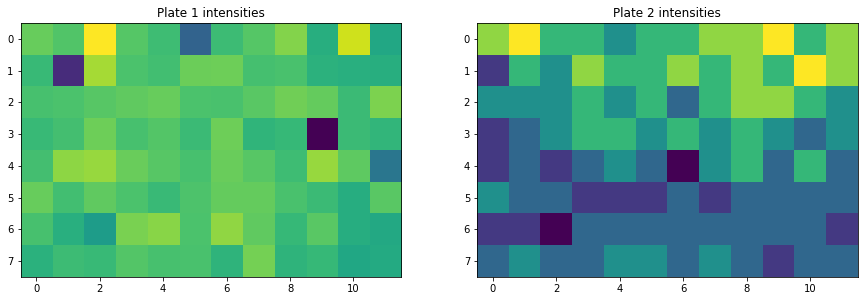

In [3]:
remove_p1 = rmv_Q2.value.split(',')
remove_p1 = [well.strip() for well in remove_p1]
remove_p2 = rmv_Q3.value.split(',')
remove_p2 = [well.strip() for well in remove_p2]



if remove_p1[0] != '':
    print(f"Plate 1 wells removed: {remove_p1}")
    for i in remove_p1:
        items = re.match(r"([a-z]+)([0-9]+)", i, re.I).groups()
        Q2.loc[items[0],int(items[1])] = np.nan

if remove_p2[0] != '':
    print(f"Plate 2 wells removed: {remove_p2}")
    for i in remove_p2:
        items = re.match(r"([a-z]+)([0-9]+)", i, re.I).groups()
        Q3.loc[items[0],int(items[1])] = np.nan


## RE-plot with removed wells
fig, axs = plt.subplots(1,2, figsize=(15,5))

plot1 = axs[0].imshow(Q2, cmap="viridis")
p1title = axs[0].set_title("Plate 1 intensities")
#fig.colorbar(plot1, ax=axs[0])

plot2 = axs[1].imshow(Q3, cmap="viridis")
p1title = axs[1].set_title("Plate 2 intensities")
#fig.colorbar(plot2, ax=axs[1])

plt.show()

___
## STEP 3:  Make standard curve
Uses Quadrant 1 (standard plate) to make a standard curve to convert fluorescence values to ng/ul

0.0037312408625639697 -2.546546127134506


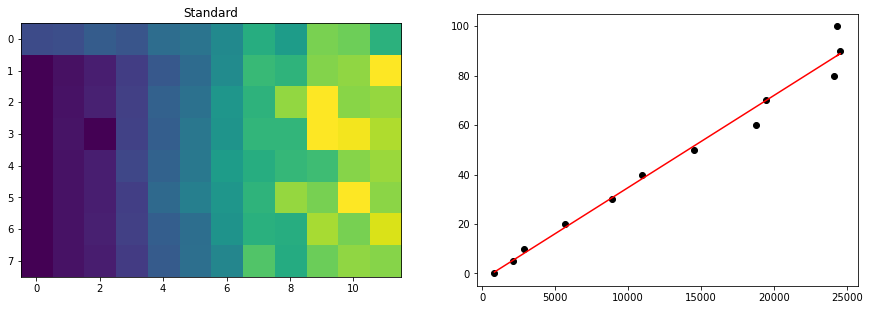

In [4]:
# Visualize AVG and CV
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].imshow(Q1_ord, cmap="viridis")
axs[0].set_title('Standard')
#colorbar()
#plt.show()

x = list(Q1_ord.mean())
plt.scatter(x, stdConc, c='k')
m,b = np.polyfit(x, stdConc, 1)
print(m, b)
axs[1].plot(x, m*np.asarray(x) + b, c='r')
#plt.show()

___
## STEP 4:  Calculate concentrations in plate
Use the standard curve to calculate ng/ul across the plates:



Hisrograms of ng/ul of the 3 plates.  DOTTED LINE indicates desired normalization value


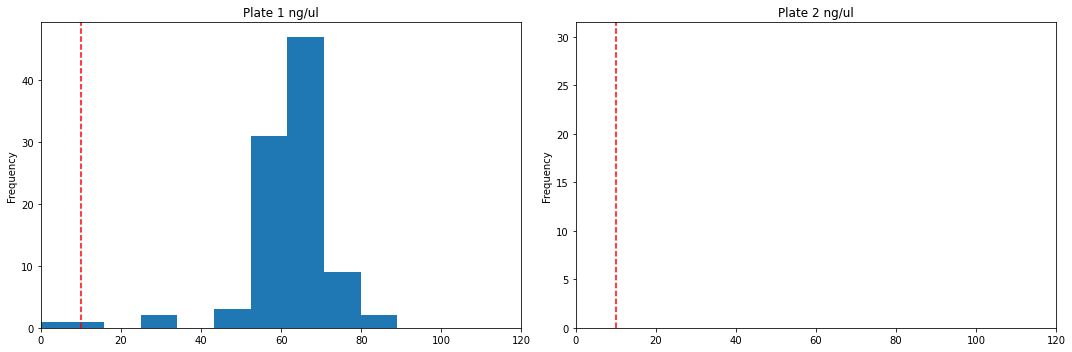

In [5]:
# Calculate concentrations sample plate 1 (quadrand 2)
Conc_1 = m*Q2+b


#Re-name row and column names to match a 96w plate
Conc_1 = Conc_1.set_axis(["A","B","C","D","E","F","G","H"],axis=0)
Conc_1 = Conc_1.set_axis(range(1,13),axis = 1)

# Calculate concentrations sample plate 2 (quadrand 3)
Conc_2 = m*Q3+b


#Re-name row and column names to match a 96w plate
Conc_2 = Conc_2.set_axis(["A","B","C","D","E","F","G","H"],axis=0)
Conc_2 = Conc_2.set_axis(range(1,13),axis = 1)






#plt.figure(figsize=(100,50))
plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1,2)
#Display histogram of concentrations plate 1
plt.axes(axs[0])
conc1_concs = Conc_1.melt()
hist1 = conc1_concs['value'].plot(kind = 'hist')
plt.title("Plate 1 ng/ul")
plt.xlim([0,120])
plt.axvline(x=finalC_1.value, color = 'r', linestyle = '--')

#Display histogram of concentrations plate 2
plt.axes(axs[1])
conc2_concs = Conc_2.melt()
hist2 = conc2_concs['value'].plot(kind = 'hist')
plt.title("Plate 2 ng/ul")
plt.xlim([0,120])
plt.axvline(x=finalC_2.value, color = 'r', linestyle = '--')




print("\n\nHisrograms of ng/ul of the 3 plates.  DOTTED LINE indicates desired normalization value")


____
## STEP 5:  Calculate volumes needed for normalization
This cell will create a new .csv file containing each plate well concentration information as well as how much volume is needed for normalization

In [7]:
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(f"{plate1.value} concentration data exported to .csv! Check your current directory")
print(f"{plate2.value} concentration data exported to .csv! Check your current directory")
print("\n")


## Plate 1:
# Linearize the data
DF_1 = pd.DataFrame(columns=['Pos','Concentration'])

for i, content in Conc_1.items():
    col_i = str(i)
    for j,k in content.iteritems():
        DF_1 = DF_1.append({'Pos':j+col_i, 'Concentration':k}, ignore_index=True)
# Calculate the volume of DNA and EB required for totalV @ finalC ng/uL
DF_1['uL_DNA'] = round(totalV_1.value*finalC_1.value / DF_1.Concentration,2)
DF_1['uL_EB'] = round(totalV_1.value-DF_1.uL_DNA,2)

print(f"Mean DNA concentration {plate1.value}: {round(DF_1['Concentration'].mean(),2)} ng/ul")
print(f"Min concentration of DNA in {plate1.value} {round(DF_1['Concentration'].min(),2)} ng/ul" )
print("\n")

plate1_export = DF_1
plate1_export = plate1_export.drop(['uL_EB'],axis = 1)
plate1_export = plate1_export.rename({"Pos":"Well","uL_DNA":"ul needed for normalization"}, axis = 1)
plate1_export = plate1_export.set_index('Well')
plate1_export = plate1_export.dropna(how = 'any')
plate1_export.to_csv(f"{plate1.value}_concentrations.csv")



## Plate 2:
# Linearize the data
DF_2 = pd.DataFrame(columns=['Pos','Concentration'])

for i, content in Conc_2.items():
    col_i = str(i)
    for j,k in content.iteritems():
        DF_2 = DF_2.append({'Pos':j+col_i, 'Concentration':k}, ignore_index=True)
# Calculate the volume of DNA and EB required for totalV @ finalC ng/uL
DF_2['uL_DNA'] = round(totalV_2.value*finalC_2.value / DF_2.Concentration,2)
DF_2['uL_EB'] = round(totalV_2.value-DF_2.uL_DNA,2)

print(f"Mean DNA concentration {plate2.value}: {round(DF_2['Concentration'].mean(),2)} ng/ul")
print(f"Min concentration of DNA in {plate2.value} {round(DF_2['Concentration'].min(),2)} ng/ul" )
print("\n")

plate2_export = DF_2
plate2_export = plate2_export.drop(['uL_EB'],axis = 1)
plate2_export = plate2_export.rename({"Pos":"Well","uL_DNA":"ul needed for normalization"}, axis = 1)
plate2_export = plate2_export.set_index('Well')
plate2_export = plate2_export.dropna(how = 'any')
plate2_export.to_csv(f"{plate2.value}_concentrations.csv")







## Negative volume handling
# Cannot pipette volumes less than or equal to 0
for i, content in DF_1.iterrows():
    if content.Concentration < finalC_1.value:
        print("ALERT!" ,content.Pos, " ",plate1.value," is below", finalC_1.value, "ng/uL!.... concentration: ", content.Concentration)
        DF_1.loc[i,'uL_DNA'] = totalV_1.value-1
        DF_1.loc[i,'uL_EB'] = 1
        
for i, content in DF_2.iterrows():
    if content.Concentration < finalC_2.value:
        print("ALERT!" ,content.Pos, " ",plate2.value," is below", finalC_2.value, "ng/uL!.... concentration: ", content.Concentration)
        DF_2.loc[i,'uL_DNA'] = totalV_2.value-1
        DF_2.loc[i,'uL_EB'] = 1
        

print("\n\n\n")

print(f"Max vol DNA to transfer from {plate1.value}: {DF_1['uL_DNA'].max()}uL")
print(f"Min vol DNA to transfer from {plate1.value}: {DF_1['uL_DNA'].min()}uL")
print(f"Mean vol DNA transfered {plate1.value}: {round(DF_1['uL_DNA'].mean(),2)}uL")
print("\n")
print(f"Max vol DNA to transfer from {plate2.value}: {DF_2['uL_DNA'].max()}uL")
print(f"Min vol DNA to transfer from {plate2.value}: {DF_2['uL_DNA'].min()}uL")
print(f"Mean vol DNA transfered {plate2.value}: {round(DF_2['uL_DNA'].mean(),2)}uL")
print("\n")


MAM-63 concentration data exported to .csv! Check your current directory
MAM-64 concentration data exported to .csv! Check your current directory


Mean DNA concentration MAM-63: 61.53 ng/ul
Min concentration of DNA in MAM-63 -2.52 ng/ul


Mean DNA concentration MAM-64: -2.51 ng/ul
Min concentration of DNA in MAM-64 -2.52 ng/ul


ALERT! B2   MAM-63  is below 10.0 ng/uL!.... concentration:  9.09492536406508
ALERT! D10   MAM-63  is below 10.0 ng/uL!.... concentration:  -2.516696200233994
ALERT! A1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.4980399959211743
ALERT! B1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.51296495937143
ALERT! C1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.505502477646302
ALERT! D1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.51296495937143
ALERT! E1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.51296495937143
ALERT! F1   MAM-64  is below 10.0 ng/uL!.... concentration:  -2.505502477646302
ALERT! G1   MAM-64  is below 10


____
### Visualize ul of DNA needed to transfer from each well to achieve desired normalization volume and concentration:
Ensure that no wells are below your normalization value

Volumes for each plate to be transfered:  Dotted line indicates average for that plate


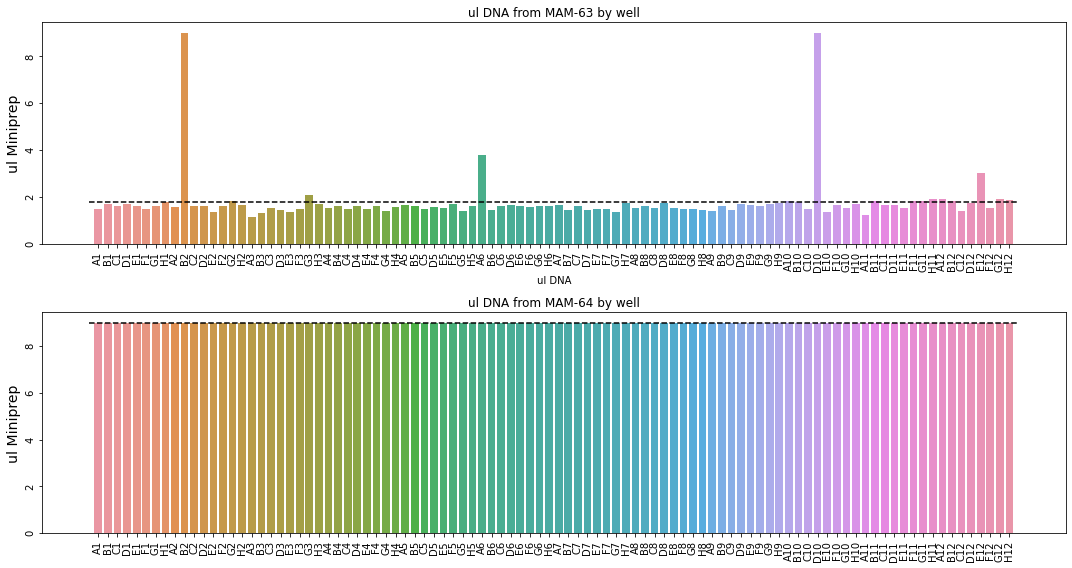

In [8]:
### PLOT VOLUME OF DNA TRANSFERED BY WELL
x_var = 'Pos'
y_var = 'uL_DNA'



print("Volumes for each plate to be transfered:  Dotted line indicates average for that plate")
#plt.figure(figsize=(100,50))
plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(2)


###PLATE 1
plt.axes(axs[0])
#plt.figure(figsize=(16,5))
plotdf = DF_1

sns.barplot(x= x_var, y= y_var, data=plotdf)
plt.tick_params(rotation=90)
plt.xlabel('ul DNA')
#plt.ylim([0,100])
plt.ylabel('ul Miniprep',size=14)
#plt.ylim([0,70])
plt.title(f'ul DNA from {plate1.value} by well',size=12)
plt.hlines(round(DF_1['uL_DNA'].mean(),2),-1,96, linestyles = 'dashed', color = 'k')

###PLATE 2
plt.axes(axs[1])
#plt.figure(figsize=(16,5))
plotdf=DF_2
sns.barplot(x = x_var,y = y_var,data=plotdf)
plt.tick_params(rotation=90)
plt.xlabel('')
#plt.ylim([0,100])
plt.ylabel('ul Miniprep',size=14)
#plt.ylim([0,70])
plt.title(f'ul DNA from {plate2.value} by well',size=12)
plt.hlines(round(DF_2['uL_DNA'].mean(),2),-1,96, linestyles = 'dashed', color = 'k')




____
## STEP 6:  Make output files for Tecan normalization
These files will be in a ".gwl" format and can be run using script AUTO-MAM-206

### First, confirm final concentrations and volumes.  If you would like to change this, go back to step 1 and re-run this entire script!

In [10]:
#Confirming concentration and volumes:

print(f'Confirm that you want to normalize {plate1.value} to:\n{finalC_1.value}ng/ul\nin a total volume of:\n{totalV_1.value}ul!\n\n{plate2.value} to:\n{finalC_2.value}ng/ul\nin a total volume of:\n{totalV_2.value}ul!\n\nIf this is incorrect, go back to top of script and rerun!')

Confirm that you want to normalize MAM-63 to:
10.0ng/ul
in a total volume of:
10.0ul!

MAM-64 to:
10.0ng/ul
in a total volume of:
10.0ul!

If this is incorrect, go back to top of script and rerun!


___
### Make .gwl files
These will be exported to your current directory.

In [11]:
## DROP nan rows so they don't end up in gwl:

DF_1 = DF_1.dropna(how = 'any')
DF_2 = DF_2.dropna(how = 'any')

######### Plate 1 ########
# Make A/D commands for GWL script

# First, make commands for EB
DF_1['A_EB'] = "A;Trough_EB;;;"+DF_1.Pos+";;"+DF_1.uL_EB.astype(str)+";"
DF_1['D_EB'] = "D;pDNA_P1_Dil;;;"+DF_1.Pos+";;"+DF_1.uL_EB.astype(str)+";"
DF_1['W_EB'] = "W;"

# Second, make commands for DNA
DF_1['A_DNA'] = "A;pDNA_P1;;;"+DF_1.Pos+";;"+DF_1.uL_DNA.astype(str)+";"
DF_1['D_DNA'] = "D;pDNA_P1_Dil;;;"+DF_1.Pos+";;"+DF_1.uL_DNA.astype(str)+";"
DF_1['W_DNA'] = "W;"

out1 = f"{plate1.value}_{int(finalC_1.value)}ngul_{int(totalV_1.value)}ul.gwl"
with open(out1,'w+') as outfile:
    # First, write the EB A/D cycles
    for index, row in DF_1.iterrows():
        outfile.write(row["A_EB"]+"\n")
        outfile.write(row["D_EB"]+"\n")
        outfile.write(row["W_EB"]+"\n")
    # Second, write the DNA A/D cycles
    for index, row in DF_1.iterrows():
        outfile.write(row["A_DNA"]+"\n")
        outfile.write(row["D_DNA"]+"\n")
        outfile.write(row["W_DNA"]+"\n")




######### Plate 2 ########
# First, make commands for EB
DF_2['A_EB'] = "A;Trough_EB;;;"+DF_2.Pos+";;"+DF_2.uL_EB.astype(str)+";"
DF_2['D_EB'] = "D;pDNA_P1_Dil;;;"+DF_2.Pos+";;"+DF_2.uL_EB.astype(str)+";"
DF_2['W_EB'] = "W;"

# Second, make commands for DNA
DF_2['A_DNA'] = "A;pDNA_P1;;;"+DF_2.Pos+";;"+DF_2.uL_DNA.astype(str)+";"
DF_2['D_DNA'] = "D;pDNA_P1_Dil;;;"+DF_2.Pos+";;"+DF_2.uL_DNA.astype(str)+";"
DF_2['W_DNA'] = "W;"


out2 = f"{plate2.value}_{int(finalC_2.value)}ngul_{int(totalV_2.value)}ul.gwl"
with open(out2,'w+') as outfile:
    # First, write the EB A/D cycles
    for index, row in DF_2.iterrows():
        outfile.write(row["A_EB"]+"\n")
        outfile.write(row["D_EB"]+"\n")
        outfile.write(row["W_EB"]+"\n")
    # Second, write the DNA A/D cycles
    for index, row in DF_2.iterrows():
        outfile.write(row["A_DNA"]+"\n")
        outfile.write(row["D_DNA"]+"\n")
        outfile.write(row["W_DNA"]+"\n")



        
print("_____________\n\nAll done! Check your current directory (where this script is) for .csv files containing ng/ul information for all wells as well as .gwl files for the Tecan normalization")

_____________

All done! Check your current directory (where this script is) for .csv files containing ng/ul information for all wells as well as .gwl files for the Tecan normalization
